In [1]:
!pip install transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("./balanced_cleaned_data.csv")
df.head()

,Rating,Review
0,1,mall terpanas padahal mall besar panas banget ...
1,2,tempatnya terawat sayang sekali duduk gazebo b...
2,3,tempat yg nagus sayang banyak sampah berseraka...
3,5,bingung malam nongkrong padang nyari tempat no...
4,3,lokasinya startegis pinggir laut sayang lengka...


In [4]:
one_hot = pd.get_dummies(df, columns=['Rating'], prefix='Rating')
labels = one_hot.iloc[:, 1:].values.astype(int)

labels[3]

array([0, 0, 0, 0, 1])

In [5]:
max_length = 512

x_ids = np.zeros((len(df), max_length))
x_attmask = np.zeros((len(df), max_length))

x_ids.shape

(741, 512)

In [1]:
from transformers import BertTokenizer

checkpoint = "indobenchmark/indobert-base-p2"

tokenizer = BertTokenizer.from_pretrained(checkpoint)

def preprocess(texts, max_len):
    input_ids = []
    attention_masks = []
    for text in texts:
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf',
        )
        input_ids.append(tokenized_text['input_ids'][0].numpy())
        attention_masks.append(tokenized_text['attention_mask'][0].numpy())

    input_ids = np.array(input_ids)
    attention_masks = np.array(attention_masks)

    return input_ids, attention_masks

/home/alridho/miniconda3/envs/simulasi/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alridho/miniconda3/envs/simulasi/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
x_ids, x_attmask = preprocess(df['Review'], max_length)

In [ ]:
# for i,text in enumerate(df["Review"]):
#   tokenized_text = tokenizer.encode_plus(
#             text,
#             max_length=max_length,
#             truncation=True,
#             padding='max_length',
#             add_special_tokens=True,
#             return_tensors='tf',
#         )
#   x_ids[i, :] = tokenized_text['input_ids']
#   x_attmask[i, :] = tokenized_text['attention_mask']
# x_ids

In [8]:
x_ids, x_attmask, labels

(array([[    2,  6408,  1036, ...,     0,     0,     0],
        [    2,  7229, 13871, ...,     0,     0,     0],
        [    2,   515,   741, ...,     0,     0,     0],
        ...,
        [    2,  2875,  1326, ...,     0,     0,     0],
        [    2,  3107, 10135, ...,     0,     0,     0],
        [    2,  1821,  2875, ...,     0,     0,     0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
 array([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        ...,
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0]]))

In [9]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices(
    (x_ids, x_attmask, labels)
)

dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(5,), dtype=tf.int64, name=None))>

In [10]:
def to_dict(input_ids, attention_mask, labels):
  return {
      'input_ids': input_ids,
      'attention_mask': attention_mask,
  }, labels

dataset = dataset.map(to_dict)

In [11]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(5,), dtype=tf.int64, name=None))>

In [12]:
batch_size = 16

dataset = dataset.shuffle(1000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.int64, name=None))>

In [13]:
split = 0.9
size = int((len(df) / batch_size) * split)
# size = int(len(df) * split)

In [14]:
train_data = dataset.take(size)
validation_data = dataset.skip(size)

In [15]:
train_data, validation_data

(<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.int64, name=None))>,
 <_SkipDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.int64, name=None))>)

In [16]:
del dataset

In [17]:
from transformers import TFAutoModel

indo_bert = TFAutoModel.from_pretrained(checkpoint)

indo_bert.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  124441344 
                                                                 
Total params: 124441344 (474.71 MB)
Trainable params: 124441344 (474.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
input_ids = tf.keras.layers.Input(shape=(max_length,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(max_length,), name='attention_mask', dtype='int32')

x = indo_bert.bert(input_ids, attention_mask=mask)[1]
x = tf.keras.layers.Dense(1024, activation='relu')(x)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [19]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=150
)

Epoch 1/150
41/41 [==============================] - 42s 753ms/step - loss: 1.8466 - accuracy: 0.2546 - val_loss: 1.4956 - val_accuracy: 0.3500
Epoch 2/150
41/41 [==============================] - 30s 731ms/step - loss: 1.5037 - accuracy: 0.3537 - val_loss: 1.7600 - val_accuracy: 0.3125
Epoch 3/150
41/41 [==============================] - 31s 750ms/step - loss: 1.4611 - accuracy: 0.3476 - val_loss: 1.4565 - val_accuracy: 0.3875
Epoch 4/150
41/41 [==============================] - 30s 744ms/step - loss: 1.4096 - accuracy: 0.3704 - val_loss: 1.4112 - val_accuracy: 0.3500
Epoch 5/150
41/41 [==============================] - 31s 748ms/step - loss: 1.4178 - accuracy: 0.3735 - val_loss: 1.3128 - val_accuracy: 0.5125
Epoch 6/150
41/41 [==============================] - 31s 747ms/step - loss: 1.3719 - accuracy: 0.3826 - val_loss: 1.3523 - val_accuracy: 0.4000
Epoch 7/150
41/41 [==============================] - 31s 746ms/step - loss: 1.3387 - accuracy: 0.4009 - val_loss: 1.2494 - val_accuracy:

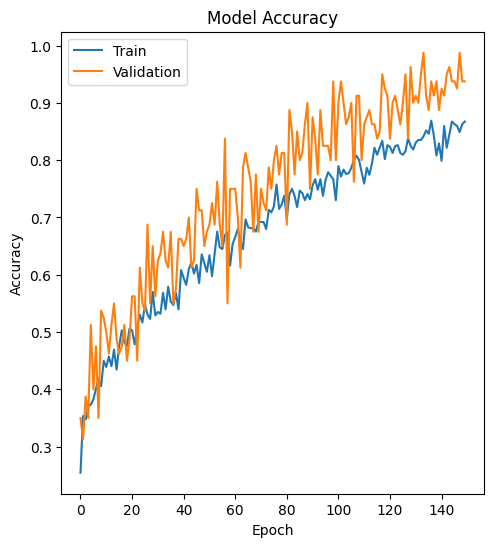

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

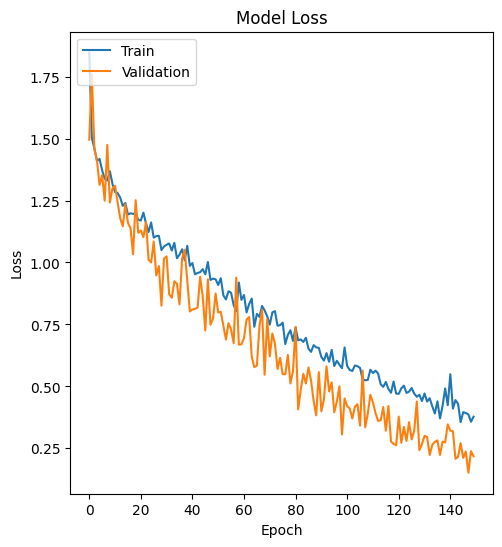

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
model.save('sentimen.h5')
print('Model Saved!')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved!


In [29]:
from google.colab import drive
drive.mount('/content/drive')

!cp sentimen.h5 /content/drive/MyDrive

Mounted at /content/drive


In [30]:
model = tf.keras.models.load_model('sentimen.h5')

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [32]:
def prep_pred(text):
  tokenized_text = tokenizer.encode_plus(
            text,
            max_length=512,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf',
        )
  return {
      'input_ids': tf.cast(tokenized_text['input_ids'], tf.float64),
      'attention_mask': tf.cast(tokenized_text['attention_mask'], tf.float64)
  }

In [40]:
text1 = "Tempatnya sangat bagus, sejuk, suasananya indah"
text2 = "Tempatnya sangat buruk, bangunan rusak, saya tidak rekomendasikan"
res1 = model.predict(prep_pred(text1))
res2 = model.predict(prep_pred(text2))
res1[0], res2[0]

1/1 [==============================] - 0s 126ms/step


(array([0.00117872, 0.04172123, 0.00609926, 0.17088224, 0.7801185 ],
       dtype=float32),
 array([2.1093246e-02, 9.7823125e-01, 9.3588551e-06, 6.2885013e-04,
        3.7215148e-05], dtype=float32))

In [42]:
print(f"Text: {text1}\nPrediksi Rating: {np.argmax(res1[0]) + 1} bintang\n")
print(f"Text: {text2}\nPrediksi Rating: {np.argmax(res2[0]) + 1} bintang\n")

Text: Tempatnya sangat bagus, sejuk, suasananya indah
Prediksi Rating: 5 bintang

Text: Tempatnya sangat buruk, bangunan rusak, saya tidak rekomendasikan
Prediksi Rating: 2 bintang

